In [1]:
# ================
# IMPORT LIBRARIES
# ================

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import gurobipy as gp
import contextlib
import os
import io
from itertools import combinations

In [2]:
# =========================
# SYNTHETIC DATA GENERATION
# =========================

np.random.seed(42)
N_ITEMS = 100
WAREHOUSE_SIZE = 20
N_ORDERS = 15000
SPIKE_ITEMS = 10
SPIKE_DAYS = 50
CONGESTION_TARGET = 2000
PEAK_QUANTILE = 0.7
PACKING_STATION = (0, 0)

# Warehouse layout
items = pd.DataFrame({
    'item_id': [f'item_{i:03d}' for i in range(N_ITEMS)],
    'x': np.random.randint(1, WAREHOUSE_SIZE, N_ITEMS),
    'y': np.random.randint(1, WAREHOUSE_SIZE, N_ITEMS),
    'base_demand': np.random.poisson(lam=3, size=N_ITEMS)
})
items['distance_to_packing'] = np.sqrt((items['x'] - PACKING_STATION[0])**2 + 
                                   (items['y'] - PACKING_STATION[1])**2)

# Generate orders
dates = pd.date_range(start='2023-01-01', end='2023-03-31')
orders = pd.DataFrame({
    'order_id': np.arange(N_ORDERS),
    'item_id': np.random.choice(items['item_id'], N_ORDERS, 
                              p=items['base_demand']/items['base_demand'].sum()),
    'date': np.random.choice(dates, N_ORDERS),
    'bundle_id': np.random.choice(['none', 'bundle_1', 'bundle_2'], N_ORDERS, 
                                p=[0.6, 0.3, 0.1]),
    'hour': np.random.choice(np.concatenate([np.arange(10,12), np.arange(14,16)]), N_ORDERS)
})

# Bundle items
bundle_items = {
    'bundle_1': ['item_001', 'item_002', 'item_003'],
    'bundle_2': ['item_005', 'item_010', 'item_015']
}
for bundle, items_in_bundle in bundle_items.items():
    bundle_mask = orders['bundle_id'] == bundle
    orders.loc[bundle_mask, 'item_id'] = np.random.choice(items_in_bundle, sum(bundle_mask))

# Generate spike days
spike_days = pd.to_datetime(np.random.choice(dates[dates.dayofweek < 5], size=SPIKE_DAYS, replace=False))

# =============================================
# CONGESTION GENERATION WITH TIMESTAMP HANDLING
# =============================================

congestion_zones = [(x,y) for x in range(5,15) for y in range(5,15)]
hourly_order_density = orders.groupby(['date', 'hour']).size()

# Get peak hours
peak_hours = hourly_order_density[hourly_order_density > hourly_order_density.quantile(PEAK_QUANTILE)]
n_peaks = len(peak_hours)

if n_peaks == 0:
    raise ValueError("No peak hours found")

# Generate timestamps
timestamps = []
for date, hour in peak_hours.index:
    timestamps.append(pd.to_datetime(f"{date} {hour}:00:00"))

# Generate congestion points
congestion = pd.DataFrame({
    'timestamp': np.repeat(timestamps, int(np.ceil(CONGESTION_TARGET/n_peaks)))[:CONGESTION_TARGET],
    'x': np.random.choice([x for x,y in congestion_zones], CONGESTION_TARGET),
    'y': np.random.choice([y for x,y in congestion_zones], CONGESTION_TARGET)
})

# print(f"Generated {len(congestion)} congestion points") # uncomment to print the number of congested points

# ==================
# DEMAND FORECASTING
# ==================

def create_features(demand_data, spike_dates, items):
    features = pd.DataFrame(index=demand_data.index)
    
    # Temporal features
    features['day_of_week'] = features.index.dayofweek
    features['is_weekend'] = features.index.dayofweek.isin([5,6])
    
    # Spike features
    features['days_since_spike'] = 0
    if len(spike_dates) > 0:
        last_spike = spike_dates.max()
        features['days_since_spike'] = np.maximum((features.index - last_spike).days, 0)
    
    # Distance features
    item_distances = items.set_index('item_id')['distance_to_packing']
    valid_items = [item for item in demand_data.columns if item in item_distances.index]
    features['avg_distance_to_packing'] = np.mean([item_distances[item] for item in valid_items]) if valid_items else 0
    
    # Bundle features
    bundle_demand_cols = [item for item in bundle_items['bundle_1'] if item in demand_data.columns]
    features['bundle_demand'] = demand_data[bundle_demand_cols].mean(axis=1) if bundle_demand_cols else 0
    
    # Lag features
    for lag in [1, 7]:
        features[f'lag_{lag}'] = demand_data.mean(axis=1).shift(lag).fillna(0)
    
    # Rolling features
    features['rolling_7day_std'] = demand_data.rolling(7, min_periods=1).std().fillna(0).mean(axis=1)
    
    return features.dropna()

# Prepare demand data
daily_demand = orders[orders['item_id'].isin(items['item_id'])].groupby(['date', 'item_id']).size().unstack(fill_value=0)

train_size = int(0.6 * len(daily_demand))
train_demand = daily_demand.iloc[:train_size]
test_demand = daily_demand.iloc[train_size:]

# Feature engineering
train_spike_days = spike_days[spike_days <= train_demand.index[-1]]
X_train = create_features(train_demand, train_spike_days, items)
y_train = train_demand.shift(-1).dropna()

# Align data
common_dates = X_train.index.intersection(y_train.index)
X_train, y_train = X_train.loc[common_dates], y_train.loc[common_dates]

# ==============
# MODEL TRAINING
# ==============

model = make_pipeline(
    StandardScaler(),
    MultiOutputRegressor(
        HistGradientBoostingRegressor(
            max_iter=100,
            max_depth=3,
            learning_rate=0.05,
            random_state=42,
            early_stopping=True
        ),
        n_jobs=-1
    )
)
model.fit(X_train, y_train)

# ================
# MODEL EVALUATION
# ================

def evaluate_model(model, X, y):
    common_dates = X.index.intersection(y.index)
    if len(common_dates) == 0:
        raise ValueError("No common dates between features and target")
    
    X_eval = X.loc[common_dates]
    y_eval = y.loc[common_dates]
    
    pred = model.predict(X_eval)
    mae = mean_absolute_error(y_eval, pred)
    
    bundle_mask = y_eval.columns.isin(bundle_items['bundle_1'])
    bundle_mae = mean_absolute_error(y_eval.loc[:, bundle_mask], pred[:, bundle_mask]) if any(bundle_mask) else 0
    
    # print(f"Overall MAE: {mae:.2f}") # uncomment to print overall MAE
    # print(f"Bundle MAE: {bundle_mae:.2f}") # uncomment to print bundle MAE
    
    return pred

# Test evaluation
X_test = create_features(test_demand, spike_days, items)
y_test = test_demand.shift(-1).dropna()
test_common_dates = X_test.index.intersection(y_test.index)
X_test, y_test = X_test.loc[test_common_dates], y_test.loc[test_common_dates]

test_pred = evaluate_model(model, X_test, y_test)

# print(f"Average Daily Demand: {y_test.mean().mean():.2f} units") # uncomment to print average daily demand



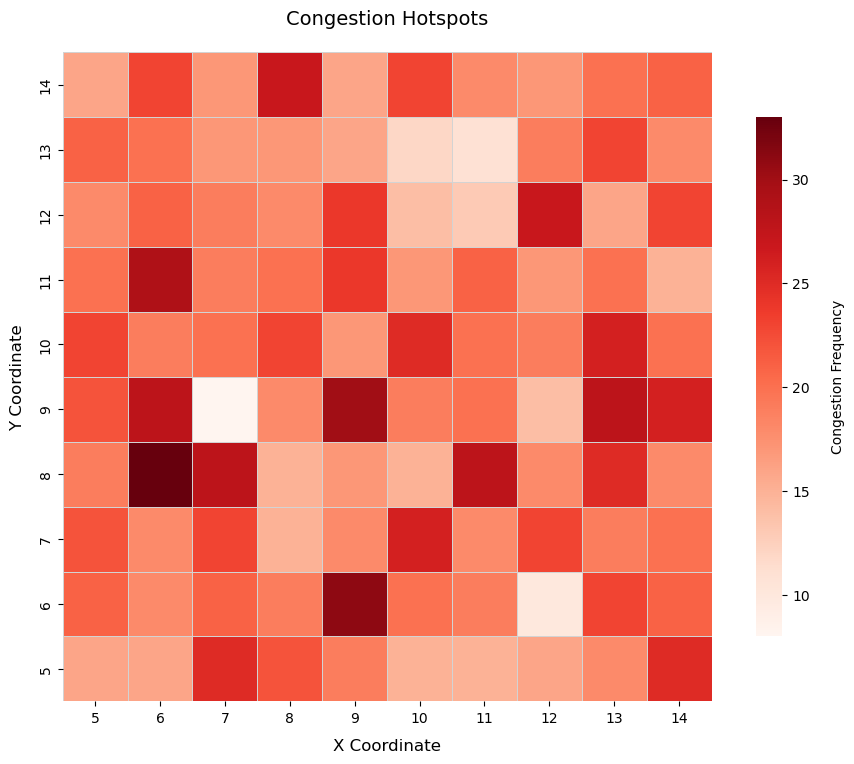

In [3]:
# ==================
# CONGESTION HEATMAP
# ==================

def plot_congestion_heatmap(congestion_df, warehouse_size=None):
    plt.figure(figsize=(10, 8))
    
    # Create heatmap data
    heatmap_data = pd.crosstab(congestion_df['y'], congestion_df['x'])
    
    # Create heatmap without annotations
    ax = sns.heatmap(heatmap_data, 
                    cmap='Reds', 
                    cbar_kws={'label': 'Congestion Frequency', 'shrink': 0.8},
                    annot=False,  # Removed numbers
                    square=True,
                    linewidths=0.5,
                    linecolor='lightgray')
    
    # Enhanced styling
    plt.title('Congestion Hotspots', pad=20, fontsize=14)
    plt.xlabel('X Coordinate', labelpad=10, fontsize=12)
    plt.ylabel('Y Coordinate', labelpad=10, fontsize=12)
    
    # Colorbar styling
    cbar = ax.collections[0].colorbar
    cbar.set_label('Congestion Frequency', rotation=90, labelpad=15)
    
    # Handle warehouse size constraints
    if warehouse_size is not None:
        if isinstance(warehouse_size, (tuple, list)):
            ax.set_xlim(0, min(warehouse_size[0], heatmap_data.shape[1]))
            ax.set_ylim(0, min(warehouse_size[1], heatmap_data.shape[0]))
        else:
            ax.set_xlim(0, min(warehouse_size, heatmap_data.shape[1]))
            ax.set_ylim(0, min(warehouse_size, heatmap_data.shape[0]))
    
    # Final layout adjustments
    plt.tight_layout(pad=2.0)
    plt.show()
    # plt.savefig("congestion_heatmap.png", dpi=300)
    

# ===================
# EXECUTION WITH DATA
# ===================
# Congestion heatmap
plot_congestion_heatmap(
    congestion,
    warehouse_size=WAREHOUSE_SIZE
)

Set parameter TimeLimit to value 60
Optimal Route:
 order         item_id  x  y
     0 PACKING_STATION  0  0
     1        item_025  3  4
     2        item_042  3  7
     3        item_010  3  7
     4        item_055  2 12
     5        item_015  1 13
     6        item_004  7 15
     7        item_009  8 14
     8        item_081  8 16
     9        item_086 10 16
    10        item_012 12 15
    11        item_062 14 17
    12        item_059 16 17
    13        item_005 19 14
    14        item_071 13 12
    15        item_095 16  8
    16        item_001 15  1
    17        item_002 11  3
    18        item_092 12  7
    19        item_040  8  9
    20        item_003  8  5

Total Cost (Distance + Congestion Penalty): 132.46


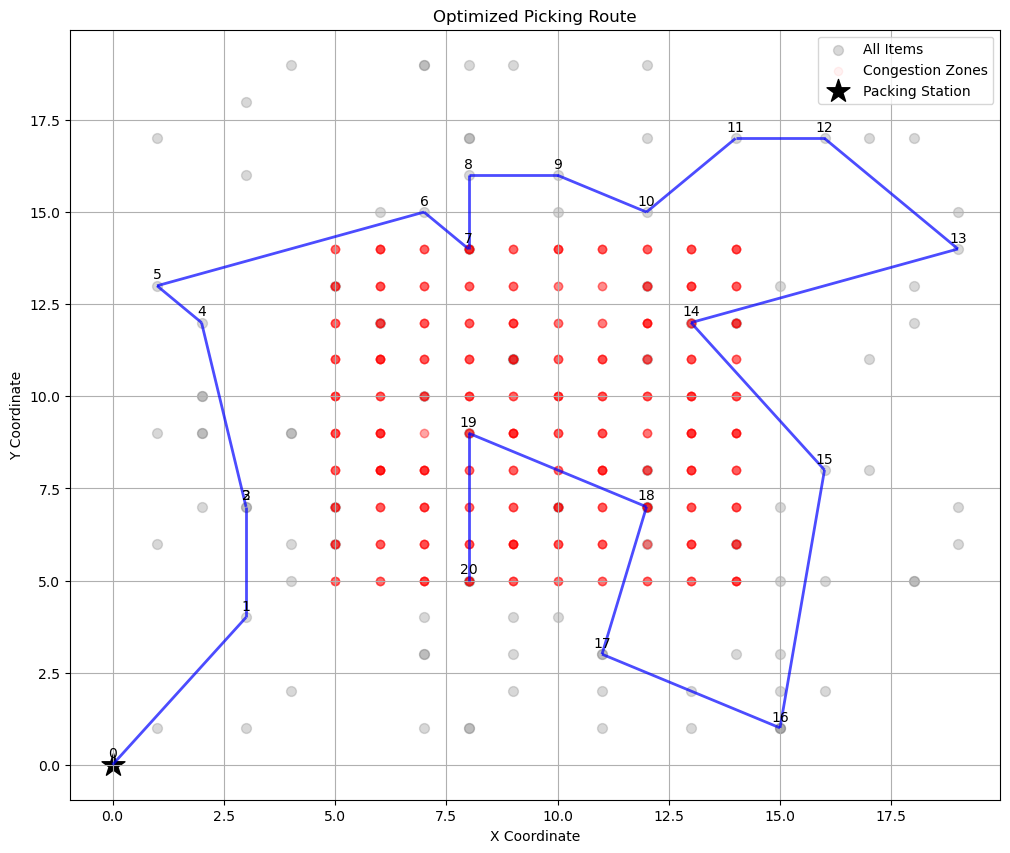

In [4]:
# ==================
# ROUTE OPTIMIZATION 
# ==================

def optimize_route(items_to_pick, congestion_zones, packing_station=(0,0), time_limit=30):
    """Identical to previous implementation"""
    n = len(items_to_pick)
    nodes = pd.concat([
        pd.DataFrame({'x': [packing_station[0]], 'y': [packing_station[1]], 'item_id': ['PACKING_STATION']}),
        items_to_pick[['x', 'y', 'item_id']]
    ]).reset_index(drop=True)
    
    with contextlib.redirect_stdout(io.StringIO()):
        m = gp.Model("Warehouse_Routing")
    m.setParam('TimeLimit', time_limit)
    
    # Suppress solver output
    m.setParam('OutputFlag', 0) # comment this line to reveal the solver output
    
    x = m.addVars(n+1, n+1, vtype=gp.GRB.BINARY, name="x")
    u = m.addVars(n+1, vtype=gp.GRB.INTEGER, name="u")
    
    dist = {
        (i,j): np.hypot(nodes.iloc[i]['x'] - nodes.iloc[j]['x'],
                        nodes.iloc[i]['y'] - nodes.iloc[j]['y'])
        for i in range(n+1) for j in range(n+1) if i != j
    }
    
    congestion_penalty = {
        (i,j): 10 if (nodes.iloc[j]['x'], nodes.iloc[j]['y']) in congestion_zones else 0
        for i in range(n+1) for j in range(n+1) if i != j
    }
    
    m.setObjective(
        gp.quicksum(dist[i,j] * x[i,j] for i,j in dist) + 
        gp.quicksum(congestion_penalty[i,j] * x[i,j] for i,j in congestion_penalty),
        gp.GRB.MINIMIZE
    )
    
    for i in range(n+1):
        m.addConstr(gp.quicksum(x[i,j] for j in range(n+1) if i != j) == 1)
        m.addConstr(gp.quicksum(x[j,i] for j in range(n+1) if i != j) == 1)
    
    for i in range(n+1):
        for j in range(1, n+1):
            if i != j:
                m.addConstr(u[i] - u[j] + (n+1)*x[i,j] <= n)
    
    m.addConstr(u[0] == 0)
    for j in range(1, n+1):
        m.addConstr(u[j] >= 1)
        m.addConstr(u[j] <= n)
    
    for i in range(n+1):
        m.addConstr(x[i,i] == 0)
    
    m.optimize()
    
    if m.status == gp.GRB.OPTIMAL:
        route = [0]
        while len(route) < n+1:
            last = route[-1]
            next_node = [j for j in range(n+1) if j != last and x[last,j].X > 0.5][0]
            route.append(next_node)
        
        optimized_route = nodes.iloc[route].copy()
        optimized_route['order'] = range(len(route))
        return optimized_route, m.ObjVal
    else:
        raise ValueError(f"No optimal solution found (Status: {m.status})")

# ====================
# RESULT VISUALIZATION 
# ====================

def visualize_route(optimized_route, items, congestion_df, packing_station=(0,0)):
    """Fixed congestion plotting"""
    plt.figure(figsize=(12, 10))
    
    # Plot all items
    plt.scatter(items['x'], items['y'], 
                s=50, alpha=0.3, c='gray', label='All Items')
    
    # Plot congested zones
    plt.scatter(congestion_df['x'], congestion_df['y'], 
                color='red', alpha=0.05, label='Congestion Zones')
    
    # Plot packing station
    plt.scatter([packing_station[0]], [packing_station[1]], 
                color='black', marker='*', s=300, label='Packing Station')
    
    # Plot optimized route
    route_points = optimized_route[['x', 'y']].values
    segments = np.stack([route_points[:-1], route_points[1:]], axis=1)
    lc = LineCollection(segments, colors='blue', linewidths=2, alpha=0.7)
    plt.gca().add_collection(lc)
    
    # Annotate route order
    for _, row in optimized_route.iterrows():
        plt.annotate(
            str(row['order']), 
            (row['x'], row['y']),
            textcoords="offset points", xytext=(0,5), ha='center'
        )
    
    plt.title(f"Optimized Picking Route")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()
    # plt.savefig("optimized_route.png")

# ================
# DATA PREPARATION 
# ================

# Get top 20 predicted items for next day
next_day_demand = pd.DataFrame(test_pred[-1:], columns=y_test.columns)  # From Step 2
top_items = next_day_demand.mean().nlargest(20).index

# Filter items DataFrame
items_to_pick = items[items['item_id'].isin(top_items)].copy()

# Convert congestion to list of tuples
congestion_zones = list(zip(congestion['x'], congestion['y']))

# =========
# EXECUTION
# =========

optimized_route, total_cost = optimize_route(
    items_to_pick=items_to_pick,
    congestion_zones=congestion_zones,
    packing_station=PACKING_STATION,
    time_limit=60
)

print("Optimal Route:")
print(optimized_route[['order', 'item_id', 'x', 'y']].to_string(index=False))
print(f"\nTotal Cost (Distance + Congestion Penalty): {total_cost:.2f}")

# Visualize 
visualize_route(optimized_route, items, congestion, PACKING_STATION)